### 1D conv model  

Run on 3 outlier clipping models for each BRCA and BLCA

From 1Dmodel_00.ipynb
    Deconstruction notes and 2D to 1D conversion

data:
../a_data_structure/normalized_data/flat

In [4]:
ls ../a_data_structure/normalized_data/flat

BLCA_X_test_flat_100k_otlr_cut_MinMax.tsv
BLCA_X_test_flat_10k_otlr_cut_MinMax.tsv
BLCA_X_test_flat_1M_otlr_cut_MinMax.tsv
BLCA_X_test_flat_1k_otlr_cut_MinMax.tsv
BLCA_X_test_flat_250_otlr_cut_MinMax.tsv
BLCA_X_test_flat_500_otlr_cut_MinMax.tsv
BLCA_X_test_flat_no_otlr_cut_MinMax.tsv
BLCA_X_train_flat_100k_otlr_cut_MinMax.tsv
BLCA_X_train_flat_10k_otlr_cut_MinMax.tsv
BLCA_X_train_flat_1M_otlr_cut_MinMax.tsv
BLCA_X_train_flat_1k_otlr_cut_MinMax.tsv
BLCA_X_train_flat_250_otlr_cut_MinMax.tsv
BLCA_X_train_flat_500_otlr_cut_MinMax.tsv
BLCA_X_train_flat_no_otlr_cut_MinMax.tsv
BLCA_y_test_flat_100k_otlr_cut_MinMax.tsv
BLCA_y_test_flat_10k_otlr_cut_MinMax.tsv
BLCA_y_test_flat_1M_otlr_cut_MinMax.tsv
BLCA_y_test_flat_1k_otlr_cut_MinMax.tsv
BLCA_y_test_flat_250_otlr_cut_MinMax.tsv
BLCA_y_test_flat_500_otlr_cut_MinMax.tsv
BLCA_y_test_flat_no_otlr_cut_MinMax.tsv
BLCA_y_train_flat_100k_otlr_cut_MinMax.tsv
BLCA_y_train_flat_10k_otlr_cut_MinMax.tsv
BLCA_y_train_flat_1M_otlr_cut_MinMax.tsv
BLCA_y_train

In [5]:
# 7 files per 2 cancers, 14 possible model runs 
7*2

14

In [6]:
# Data import and setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
train_norm = pd.read_csv('../a_data_structure/normalized_data/flat/BLCA_X_train_flat_10k_otlr_cut_MinMax.tsv',
                  sep = '\t',
                   index_col = 0)

In [8]:
test_norm = pd.read_csv('../a_data_structure/normalized_data/flat/BLCA_X_test_flat_10k_otlr_cut_MinMax.tsv',
                  sep = '\t',
                   index_col = 0)

In [9]:
train_norm.shape

(299, 20530)

In [10]:
test_norm.shape

(100, 20530)

In [ ]:
# Concept note:
# filters go up through encoder layers, outward in detail
# e.g. 8 first, then 16 on next layer

In [11]:
train_norm_arr = train_norm.to_numpy()
train_norm_arr_exp = np.expand_dims(train_norm_arr, axis=-1)

In [12]:
train_norm_arr.shape

(299, 20530)

In [13]:
train_norm_arr_exp.shape

(299, 20530, 1)

In [ ]:
train_norm_arr

In [14]:
test_norm_arr = test_norm.to_numpy()
test_norm_arr_exp = np.expand_dims(test_norm_arr, axis=-1)

In [ ]:
# where is the

In [15]:
# 1Dconv

latent_dim = 100

import tensorflow as tf; tf.compat.v1.disable_eager_execution()

from keras import backend as K
from keras.layers import (Input, # want float.64 to go into this layer, two input layers (enc and dec)
                          Conv1D,
                          Dense,
                          Conv1DTranspose,
                          Flatten,
                          Lambda,
                          Reshape)
from keras.models import Model

from keras.losses import binary_crossentropy

print('libraries done')

tf.executing_eagerly()

def compute_latent(x):
    batch = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    eps = K.random_normal(shape=(batch,dim))
    return mu + K.exp(sigma/2)*eps

def kl_reconstruction_loss(true, pred):                                                  
    reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred))
    kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    return K.mean(reconstruction_loss + kl_loss)

encoder_input = Input(shape=(train_norm.shape[1],1,))

encoder_conv = Conv1D(filters=8,
                      kernel_size=3,
                      activation='relu',
                      padding='same')(encoder_input)

encoder_conv = Conv1D(filters=16,
                      kernel_size=3,
                      padding='same',
                      activation='relu')(encoder_conv)

encoder = Flatten()(encoder_conv)

mu = Dense(latent_dim)(encoder)
sigma = Dense(latent_dim)(encoder)

latent_space = Lambda(compute_latent, output_shape=(latent_dim,))([mu, sigma])
                    
conv_shape = K.int_shape(encoder_conv)

# Decoder start
decoder_input = Input(shape=(latent_dim,))

decoder = Dense(conv_shape[1]*conv_shape[2], activation='relu')(decoder_input)
decoder = Reshape((conv_shape[1], conv_shape[2]))(decoder)

decoder_conv = Conv1DTranspose(filters=16,
                      kernel_size=3,
                      padding='same',
                      activation='relu')(decoder)

decoder_conv = Conv1DTranspose(filters=8,
                      kernel_size=3,
                      activation='relu',
                      padding='same')(decoder_conv)

decoder_conv = Conv1DTranspose(filters=1,
                      kernel_size=3,
                      activation='relu',
                      padding='same')(decoder_conv)

encoder = Model(encoder_input, latent_space)
decoder = Model(decoder_input, decoder_conv)
vae = Model(encoder_input, decoder(encoder(encoder_input)))
vae.compile(optimizer='adam', loss=kl_reconstruction_loss)  # blank model set for (pre)training
print('model built')

2022-10-13 11:03:38.838442: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


libraries done
model built


In [18]:
mkdir decoded

In [21]:
encoder.summary() # kernel restart, Layer names reset, shapes same

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20530, 1)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 20530, 8)     32          ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 20530, 16)    400         ['conv1d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 328480)       0           ['conv1d_1[0][0]']               
                                                                                              

In [22]:
decoder.summary() # kernel restart

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_2 (Dense)             (None, 328480)            33176480  
                                                                 
 reshape (Reshape)           (None, 20530, 16)         0         
                                                                 
 conv1d_transpose (Conv1DTra  (None, 20530, 16)        784       
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 20530, 8)         392       
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 20530, 1)         25  

In [ ]:
# last number is number of filters

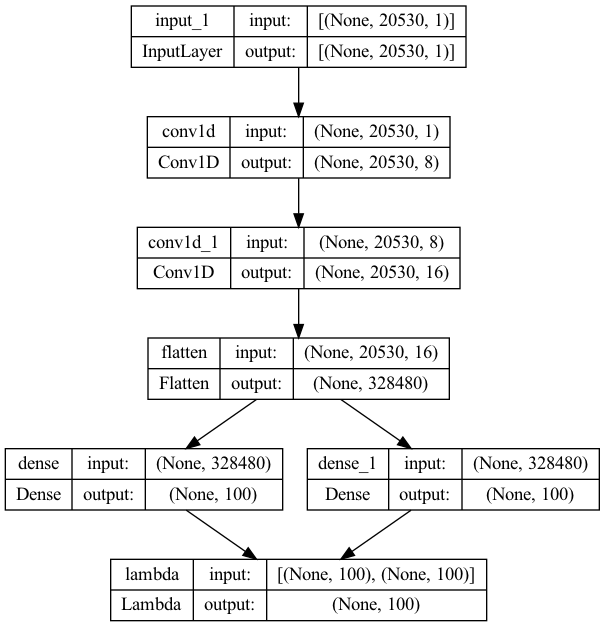

In [23]:
tf.keras.utils.plot_model(
    encoder,
    show_shapes=True,
    to_file='./loss_curves_ignored/1D_model_r0.png')

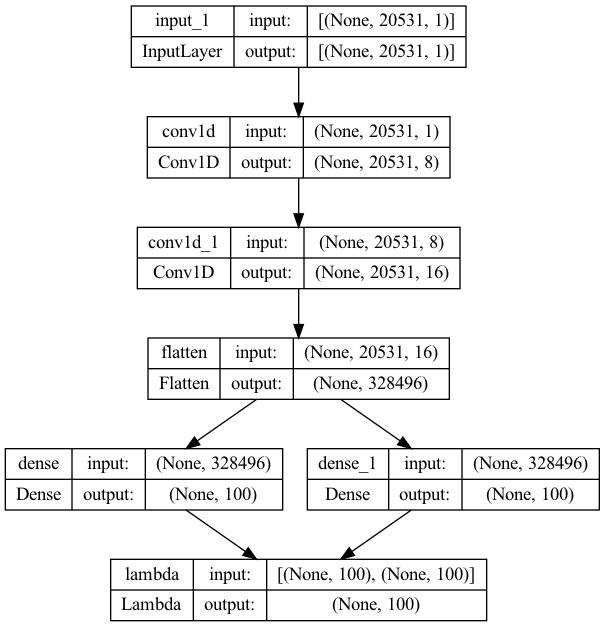

In [14]:
tf.keras.utils.plot_model(
    encoder,
    show_shapes=True,
    to_file='./loss_curves_ignored/1D_enc_v3.png')

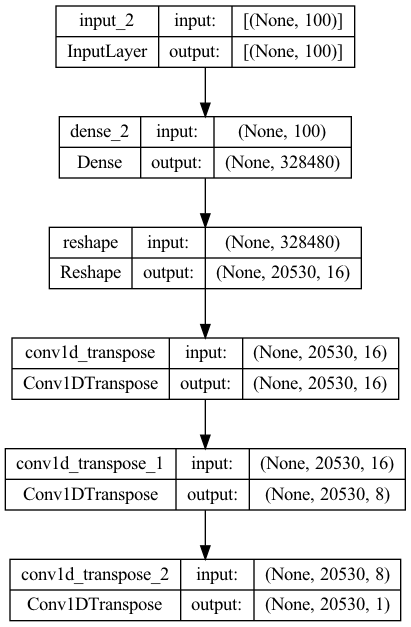

In [24]:
tf.keras.utils.plot_model(
    decoder,
    show_shapes=True,
    to_file='./loss_curves_ignored/1D_dec_model_r0.png')

In [25]:
epochs = 5

In [26]:
cohort = 'BLCA'

In [27]:
version = '1D_model_r0.ipynb'

In [28]:
date = '2022-10-12'

In [ ]:
batch_size = 128

In [29]:
batch_size = 64

In [22]:
batch_size = 32

In [30]:
# fit, restart kernel and recompile model between runs

history = vae.fit(x=train_norm_arr_exp, y=train_norm_arr_exp, epochs=epochs,
                  batch_size=batch_size,
                  validation_data=(test_norm_arr_exp, test_norm_arr_exp))

# history = vae.fit(x=train_norm, y=train_norm, epochs=epochs,
#                   batch_size=batch_size,
#                   validation_data=(test_norm, test_norm))

Train on 299 samples, validate on 100 samples
Epoch 1/5


2022-10-12 20:17:29.839440: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-12 20:17:29.890180: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


299/299 [==============================] - ETA: 0s - loss: 267.0979

/Users/karlberb/Desktop/RNB00978/sample_count/sample_gen/dense_layer/dense_full_env_00/lib/python3.9/site-packages/keras/engine/training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


299/299 [==============================] - 15s 51ms/sample - loss: 267.0979 - val_loss: 260.7024
Epoch 2/5
299/299 [==============================] - 13s 44ms/sample - loss: 150.3349 - val_loss: 171.9434
Epoch 3/5
299/299 [==============================] - 14s 47ms/sample - loss: 137.7686 - val_loss: 85.8236
Epoch 4/5
299/299 [==============================] - 10s 32ms/sample - loss: 75.9223 - val_loss: 82.7606
Epoch 5/5
299/299 [==============================] - 10s 34ms/sample - loss: 56.9618 - val_loss: 38.5533


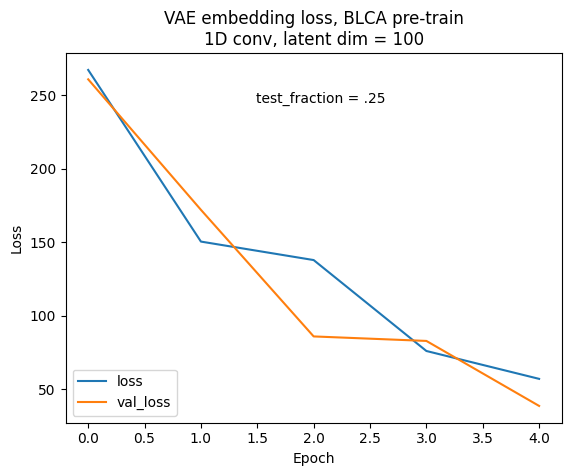

In [31]:
plt.plot(history.history['loss'],label="loss")
plt.plot(history.history['val_loss'],label="val_loss")
plt.title('VAE embedding loss, '+cohort+' pre-train\n'+
          '1D conv, latent dim = '+str(latent_dim))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.annotate('test_fraction = .25',
            xy=(.4, .8), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            # fontsize=20
            )

plt.legend(loc="lower left")
plt.savefig('loss_curves_ignored/'+cohort+'_pretrain_'+
            str(epochs)+'_epochs_'+
            str(latent_dim)+'_latent_dim_'+
            date+'_'+version+'_r0.png')

In [32]:
trn_ltnt = encoder.predict(train_norm_arr_exp)

/Users/karlberb/Desktop/RNB00978/sample_count/sample_gen/dense_layer/dense_full_env_00/lib/python3.9/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [33]:
tst_ltnt = encoder.predict(train_norm_arr_exp)

In [34]:
trn_dec = decoder.predict(trn_ltnt)

In [35]:
tst_dec = decoder.predict(tst_ltnt)

In [ ]:
# inverse of expand 

In [36]:
tst_dec.shape

(299, 20530, 1)

In [ ]:
# to send to UMAP